In [1]:
# Step 1: Install the datasets library
!pip install -U datasets


# Step 2: Import the load_dataset function
from datasets import load_dataset


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
# Step 3: Load the Amazon Polarity dataset
dataset = load_dataset("amazon_polarity")

# Step 4: Inspect the dataset
print(dataset)                # Show dataset splits


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})


In [3]:
# View the first example in the training set
print(dataset['train'][0])


{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}


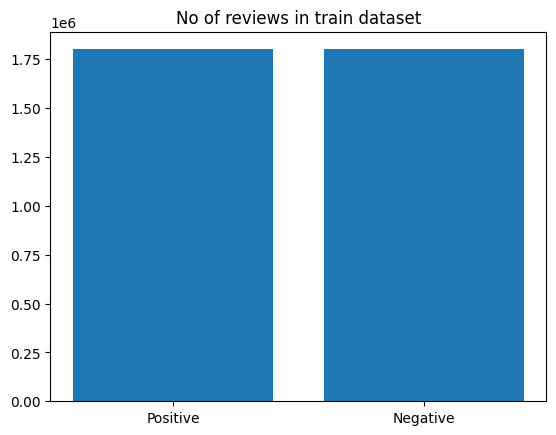

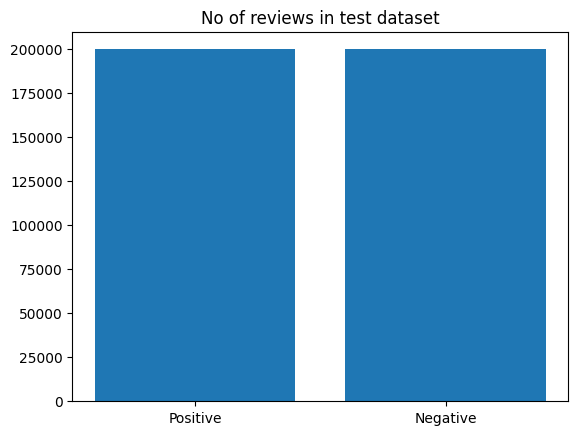

In [4]:
# EDA
import matplotlib.pyplot as plt
value_count_train = {
    'Positive': (dataset['train']['label']).count(1),
    'Negative': (dataset['train']['label']).count(0)
}

plt.bar(value_count_train.keys(), value_count_train.values())
plt.title('No of reviews in train dataset')
plt.show()

value_count_test = {
    'Positive': (dataset['test']['label']).count(1),
    'Negative': (dataset['test']['label']).count(0)
}

plt.bar(value_count_test.keys(), value_count_test.values())
plt.title('No of reviews in test dataset')
plt.show()

In [5]:
# 5. Preprocessing and Tokenization
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
def preprocess(example):
    return tokenizer(example["content"], truncation=True, padding="max_length", max_length=256)

tokenized_dataset = dataset.map(preprocess, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [7]:
# 6. Load Pretrained BERT Model for Classification
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# 7. Training Setup
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # <-- updated argument name
    per_device_train_batch_size=8,
    num_train_epochs=10,
    logging_dir="./logs",
    report_to="none"  # disables W&B and other integrations
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"].shuffle(seed=42).select(range(10000)),  # subset for quick training
    eval_dataset=tokenized_dataset["test"].shuffle(seed=42).select(range(2000)),
)

In [9]:
# 8. Train the Model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.350400,0.327936
2,0.194300,0.334475
3,0.120200,0.415849
4,0.059600,0.473911
5,0.031700,0.507555
6,0.024100,0.581984
7,0.012700,0.705548
8,0.004400,0.673793
9,0.008000,0.688787
10,0.002300,0.709008


TrainOutput(global_step=12500, training_loss=0.07846513010025025, metrics={'train_runtime': 5449.1196, 'train_samples_per_second': 18.352, 'train_steps_per_second': 2.294, 'total_flos': 1.3155552768e+16, 'train_loss': 0.07846513010025025, 'epoch': 10.0})

In [10]:
# 9. Evaluate the Model
results = trainer.evaluate()
print("Evaluation Results:", results)


Evaluation Results: {'eval_loss': 0.7090079188346863, 'eval_runtime': 31.5233, 'eval_samples_per_second': 63.445, 'eval_steps_per_second': 7.931, 'epoch': 10.0}


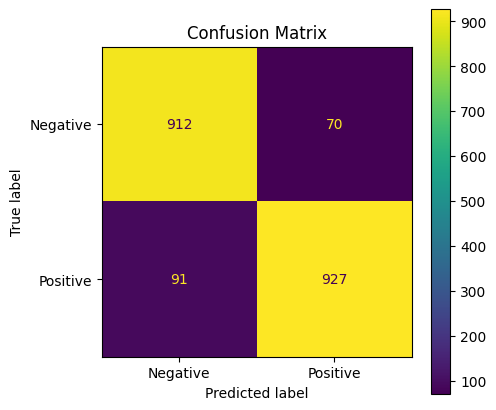

In [11]:
# 10. Plot Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Get predictions on the evaluation dataset
preds_output = trainer.predict(trainer.eval_dataset)

# 2. Extract predicted labels and true labels
predictions = preds_output.predictions.argmax(axis=1)
true_labels = preds_output.label_ids

# 3. Compute and plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)
plt.title("Confusion Matrix")
plt.show()


In [13]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       982
           1       0.93      0.91      0.92      1018

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [14]:
sample_dataset = trainer.eval_dataset.select(range(20))

for i in range(min(10, len(predictions))):
    input_ids = sample_dataset[i]["input_ids"]
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)

    print(f"Example {i+1}:")
    print(f"  Text           : {decoded_text}")
    print(f"  True Label     : {true_labels[i]}")
    print(f"  Predicted Label: {predictions[i]}")
    print()

Example 1:
  Text           : the product works fine. i ordered the more exprensive one after i read reviews from others on amazon. my husband likes the presser. it does a good job pressing his pants. however, it was damaged in the box when we received it. we decided it was too much trouble to send it back. the box was torn and the presser had a chuck knocked out of it.
  True Label     : 1
  Predicted Label: 0

Example 2:
  Text           : this book is so useless that i feel compelled to write a review to warn others to stay away from this book. a good tutorial should inspire the user on what he / she can do with the product. this book leads you to believe that without talent, the only thing you can do with illustrator is to draw circles and squares. the book is a disservice to both the reader and to adobe illustrator.
  True Label     : 0
  Predicted Label: 0

Example 3:
  Text           : the authors attempt an ambitious goal of covering many soa topics - but their resulting text c